In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

from drn_interactions.brain_state_decode import StateDecodeDataLoader, StateDecodePreprocessor, StateEncoder
from drn_interactions.load import load_derived_generic, load_neurons_derived

sns.set_theme(context="poster", style="ticks")


c:\Users\roryl\.conda\envs\drn38\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def eeg_encode(
    loader: StateDecodeDataLoader,
    preprocessor:StateDecodePreprocessor,
    encoder: StateEncoder,
    ):
    spikes, states = loader()
    spikes, states = preprocessor(spikes, states)
    spikes.columns = spikes.columns.map(str)
    
    pop = encoder.get_pop_scores(spikes, states)
    state = encoder.get_state_scores(spikes, states)
    comb = encoder.get_combined_scores(spikes, states)
    frames = []
    for name, df in (("pop", pop), ("state", state), ("comb", comb)):
        df1 = pd.DataFrame(df).mean().to_frame(name)
        df1 = df1.reset_index().rename(columns={"index": "neuron_id"})
        frames.append(df1)
    df = pd.merge(frames[0], frames[1]).merge(frames[2])
    return df

def eeg_encode_multi(sessions, loader, preprocessor, encoder):
    out = []
    for session in sessions:
        print(session) 
        loader_session = deepcopy(loader)
        loader_session.set_session(session)
        df = eeg_encode(loader_session, preprocessor, encoder)
        df = df.assign(session_name=session)
        out.append(df)
    return pd.concat(out).reset_index(drop=True)

In [3]:
eeg_states = load_derived_generic("eeg_states.csv").rename(columns={"cluster": "state"})
neurons = load_neurons_derived()
sessions = neurons.merge(eeg_states[["session_name"]].drop_duplicates(), on="session_name")["session_name"].unique()


In [5]:
ct = make_column_transformer(
       (StandardScaler(),
        make_column_selector(dtype_exclude=object)),  # standardize numeric columns
       (OneHotEncoder(),
        make_column_selector(dtype_include=object)),   # one-hot encode categorical columns
        )

estimator = make_pipeline(ct, 
    RandomForestRegressor(n_estimators=50, max_depth=8, n_jobs=-1)
)

loader =StateDecodeDataLoader(
    session_name=sessions[10],
    block="pre",
    t_start=0,
    t_stop=1800,
    bin_width=1,
    )
preprocessor = StateDecodePreprocessor(thresh_empty=2)
cv = KFold(shuffle=True)
encoder = StateEncoder(
    estimator=estimator,
    cv=cv,
    scoring="r2"
)

df = eeg_encode_multi(sessions, loader, preprocessor, encoder)

[Text(0, 0, 'EEG State'), Text(1, 0, 'Population\nActivity')]

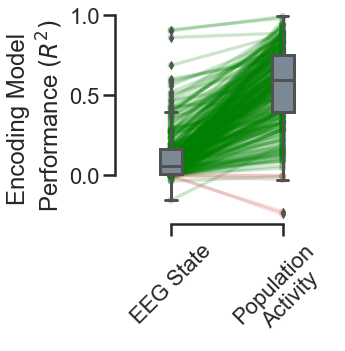

In [43]:
idx = df.set_index(["neuron_id", "session_name"]).apply(lambda x: (x < -0.3).any(), axis=1)
df2 = df[~idx.values]
df1 =  df2.melt(id_vars=["neuron_id", "session_name"])

fig, ax = plt.subplots(ncols=1, figsize=(4, 4), sharey=True)


pg.plot_paired(
    data=df1.query("variable != 'comb'"), 
    dv='value', 
    within='variable',
    subject='neuron_id',
    boxplot=True,
    order=["state", "pop"],
    boxplot_in_front=True,
    pointplot_kwargs={"alpha": 0.2},
    ax=ax
    )

ax.set_xlabel(None)
ax.set_ylabel("Encoding Model \nPerformance $(R^{2})$", )
ax.set_xticklabels(["EEG State", "Population\nActivity"], rotation=45, )

In [1]:
# shufflers

def shuffle_cols(spikes, states):
    # breaks correlations, breaks associations with states
    spikes = spikes.apply(np.random.permutation)
    return spikes, states


def shuffle_rows(spikes, states):
    # maintains correlations, breaks associations with states
    spikes = spikes.copy().sample(frac=1)
    spikes.index = states.index
    return spikes, states


In [7]:
# shuffle 
def shuffle_cols(spikes, states):
    # breaks correlations
    spikes = spikes.apply(np.random.permutation)
    return spikes, states



shuffle_preprocessor = StateDecodePreprocessor(thresh_empty=2, shuffle=shuffle_cols)
df_shuff = eeg_encode_multi(sessions, loader, shuffle_preprocessor, encoder)

ESHOCK_03_LOC1


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


ESHOCK_04_LOC1


100%|██████████| 23/23 [00:13<00:00,  1.72it/s]


ESHOCK_06_LOC1


100%|██████████| 22/22 [00:12<00:00,  1.82it/s]


ESHOCK_07_LOC1


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


ESHOCK_08_LOC1


100%|██████████| 30/30 [00:16<00:00,  1.83it/s]


ESHOCK_09_LOC1


100%|██████████| 36/36 [00:20<00:00,  1.71it/s]


hamilton_10


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


hamilton_03


100%|██████████| 9/9 [00:04<00:00,  1.80it/s]


hamilton_04


100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


hamilton_09


100%|██████████| 12/12 [00:07<00:00,  1.69it/s]


acute_15


100%|██████████| 30/30 [00:18<00:00,  1.61it/s]


acute_16


100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


acute_14


100%|██████████| 19/19 [00:11<00:00,  1.71it/s]


acute_12


100%|██████████| 37/37 [00:22<00:00,  1.64it/s]


acute_11


100%|██████████| 34/34 [00:20<00:00,  1.64it/s]


[Text(0, 0, 'EEG State'), Text(1, 0, 'Shuffled\nPopulation\nActivity')]

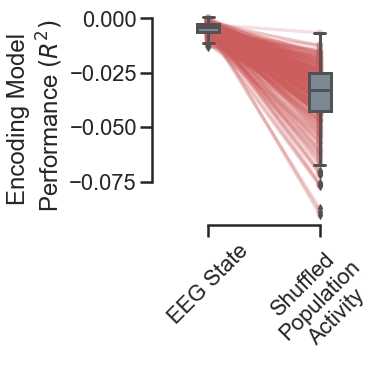

In [10]:
idx = df_shuff.set_index(["neuron_id", "session_name"]).apply(lambda x: (x < -0.1).any(), axis=1)
df2 = df_shuff[~idx.values]

fig, ax = plt.subplots(ncols=1, figsize=(4, 4), sharey=True)

df1 =  df2.melt(id_vars=["neuron_id", "session_name"])

pg.plot_paired(
    data=df1.query("variable != 'comb'"), 
    dv='value', 
    within='variable',
    subject='neuron_id',
    boxplot=True,
    order=["state", "pop"],
    boxplot_in_front=True,
    pointplot_kwargs={"alpha": 0.2},
    ax=ax
    )

ax.set_xlabel(None)
ax.set_ylabel("Encoding Model \nPerformance $(R^{2})$", )
ax.set_xticklabels(["EEG State", "Shuffled\nPopulation\nActivity"], rotation=45, )